In [ ]:
!pip install pandarallel

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, make_scorer, roc_curve
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD

from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Doc2Vec

from sklearn.pipeline import Pipeline

import unicodedata
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import SnowballStemmer, PorterStemmer
import string
import nltk
from nltk.tokenize import sent_tokenize, wordpunct_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
import pandas as pd
import re
from pandarallel import pandarallel
from pandarallel.utils import progress_bars
from tqdm import tqdm


import gensim
from gensim.models import Word2Vec,KeyedVectors

tqdm.pandas()
pandarallel.initialize(progress_bar=True)
progress_bars.is_notebook_lab = lambda : True
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data preparation

All the data preparation can be seen in the previous home work: https://colab.research.google.com/drive/11rejVFJ5Yx96DOGYBI8O0b5O1ulWA54v?usp=sharing.

In [ ]:
%%time
df = pd.read_json('drive/MyDrive/training/HW/data/normalized.json', )[['lemm', 'sent']]
display(df)

,lemm,sent
0,"[one, reviewer, mention, watch, oz, episode, h...",1
1,"[wonderful, little, production, filming, techn...",1
2,"[think, wonderful, way, spend, time, hot, summ...",1
3,"[basically, family, little, boy, jake, think, ...",0
4,"[petter, mattei, love, time, money, visually, ...",1
...,...,...
49995,"[think, movie, right, good, job, creative, ori...",1
49996,"[bad, plot, bad, dialogue, bad, acting, idioti...",0
49997,"[catholic, taught, parochial, elementary, scho...",0
49998,"[go, disagree, previous, comment, side, maltin...",0


CPU times: user 18.4 s, sys: 2.48 s, total: 20.9 s
Wall time: 21 s


In [ ]:
df['sent'].value_counts()

1    25000
0    25000
Name: sent, dtype: int64

# Baseline model

The datset is balanced, so accuracy can be a good metric. 

We will start with baseline model. We will define function for pipeline creation.

In [ ]:
def identity(words):
  return words

def create_pipeline(estimator):

  steps = [
      ('vectorize', TfidfVectorizer(
          tokenizer=identity, preprocessor=None, lowercase=False
      ))
  ]

  # Add the estimator
  steps.append(('classifier', estimator))
  return Pipeline(steps)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df['lemm'], df['sent'], test_size=0.25, shuffle=True, random_state=42)

pipe = create_pipeline(LogisticRegression())

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
y_pred_train = pipe.predict(X_train)

y_pred_prob = pipe.predict_proba(X_test)
y_pred_train_prob = pipe.predict_proba(X_train)

print(classification_report(y_test, y_pred))

print("Accuracy train:", accuracy_score(y_train, y_pred_train))
print("Accuracy test: ", accuracy_score(y_test, y_pred))

print("ROC AUC train:", roc_auc_score(y_train, y_pred_train_prob[:, 1]))
print("ROC AUC test: ", roc_auc_score(y_test, y_pred_prob[:, 1]))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      6157
           1       0.88      0.91      0.89      6343

    accuracy                           0.89     12500
   macro avg       0.89      0.89      0.89     12500
weighted avg       0.89      0.89      0.89     12500

Accuracy train: 0.92888
Accuracy test:  0.892
ROC AUC train: 0.9793802770773801
ROC AUC test:  0.9590675705706972


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Embedding, Flatten, Dropout, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
import keras
import numpy as np
import pandas as pd

from keras.preprocessing.text import Tokenizer
import gensim
import pandas as pd
import numpy as np
from itertools import chain

import tensorflow_hub as hub
import numpy as np

# Texts to sequences

It is very expensive to store vectors for each word in a dataframe. So, we can transform texts into sequences of indicies. So, this requires much less space, and we can use Embedding layer to convert sequences to vectors.

In [ ]:
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(X_train)
vocab_size = len(t.word_index) + 1

In [ ]:
# integer encode the documents
X_train_seq = t.texts_to_sequences(X_train)
X_test_seq = t.texts_to_sequences(X_test)

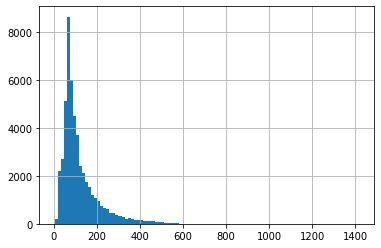

In [ ]:
df['lemm'].apply(lambda x: len(x)).hist(bins=100);

In [ ]:
# pad documents to a max length of 4 words
max_length = int(df['lemm'].apply(lambda x: len(x)).quantile(0.9))
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

In [ ]:
X_train_pad

array([[ 435, 3188,  461, ...,    0,    0,    0],
       [ 137,    1,   48, ...,    0,    0,    0],
       [ 133,   13,    1, ...,    0,    0,    0],
       ...,
       [ 527,    3,  293, ...,    0,    0,    0],
       [ 231,   95,  329, ...,    0,    0,    0],
       [ 423,    1,  166, ...,    0,    0,    0]], dtype=int32)

# Recurrent NNs

In this work will be used 2 embedding types and 2 NN types. The best model will be chosen using model checkpoints, and early stopping will also be used.

## Glove

In [ ]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('drive/MyDrive/training/HW/data/glove.6B.300d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [ ]:
embeddings_index['school']

array([-6.4161e-01,  6.8240e-02,  5.1487e-02,  6.4869e-02,  2.1723e-01,
        5.4558e-02,  1.3024e-01, -1.0667e-01,  1.4072e-01, -9.3076e-01,
        1.7477e-01,  4.2712e-01,  6.6720e-01,  4.4806e-01,  4.0159e-02,
        3.3519e-01,  6.9483e-03, -7.3516e-01,  4.0616e-01, -6.5180e-01,
        5.2317e-02, -2.7736e-01, -8.1789e-02,  5.5772e-01, -1.4005e-01,
        2.0077e-01, -1.5129e-01,  2.4109e-02,  2.0042e-01, -1.8521e-03,
        1.0963e+00, -3.2770e-01,  1.4748e-01,  8.3094e-01, -8.9014e-01,
        3.2464e-02, -1.4011e-01, -5.8803e-03, -2.4651e-01, -2.1943e-01,
        2.2134e-01, -7.0916e-01, -3.3977e-01,  2.2341e-01,  4.5329e-01,
        2.9131e-01, -1.9803e-02,  6.3039e-01,  6.0066e-01, -5.5588e-01,
        7.9623e-02, -2.1045e-01, -4.6800e-02, -4.7401e-01,  9.2838e-02,
       -1.4301e-01,  6.2879e-02,  2.9913e-01, -5.9922e-02, -3.6503e-01,
       -5.4157e-02,  6.3134e-02,  4.1571e-01,  2.6924e-01,  1.8764e-01,
       -7.4354e-01,  1.1313e-01, -3.2984e-01, -5.5670e-01, -4.88

In [ ]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape, vocab_size

((82269, 300), 82269)

In [ ]:
X_test_pad

array([[   19,     5, 43972, ...,     0,     0,     0],
       [   46,   560,    20, ...,     0,     0,     0],
       [    2,   772,     8, ...,     0,     0,     0],
       ...,
       [ 3049,     1,    16, ...,     0,     0,     0],
       [ 1829,    19,   152, ...,     0,     0,     0],
       [ 1470,    62,  3485, ...,     0,     0,     0]], dtype=int32)

In [ ]:
# 
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# 
es_callback = EarlyStopping(monitor='val_loss', patience=4, )


## LSTM (Glove)

### Model

In [ ]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable=False, )

model.add(embedding_layer)
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# summarize the model
print(model.summary())

# fit the model
history = model.fit(X_train_pad, y_train, epochs=25, verbose=1, validation_split=0.1,
    callbacks=[model_checkpoint_callback, es_callback])

# evaluate the model
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=0)
print('Accuracy: %f' % (accuracy*100))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 233, 300)          24680700  
_________________________________________________________________
lstm_4 (LSTM)                (None, 233, 128)          219648    
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 25,032,061
Trainable params: 351,361
Non-trainable params: 24,680,700
_________________________________________________________________
None
Epoch 1/25
1055/1055 [==============================] - 94s 86ms/step - loss: 0.6877 - accuracy: 

In [ ]:
model.load_weights(checkpoint_filepath)
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=0)
print('Accuracy of the best model on val: %f' % (accuracy*100))

Accuracy of the best model on val: 87.944001


In [ ]:
y_pred_lstm_glove = model.predict(X_test_pad)

### Learning curves

In [ ]:
def plot_history(history):
  plt.plot(history.history['accuracy'][1:], 
          label='accuracy train')
  plt.plot(history.history['val_accuracy'][1:], 
          label='accuracy test')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.show()

  plt.plot(history.history['loss'][1:], 
          label='loss train')
  plt.plot(history.history['val_loss'][1:], 
          label='loss test')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.show()

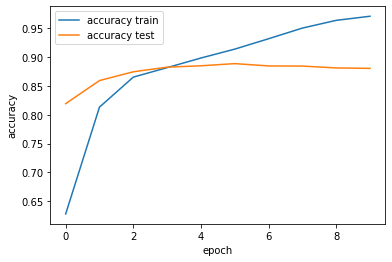

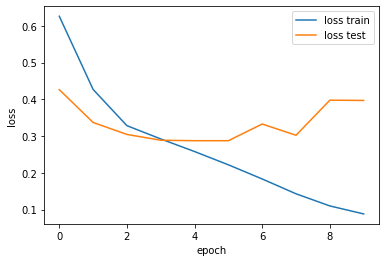

In [ ]:
plot_history(history)

## Bidirectional LSTM (Glove)

### Model

In [ ]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable=False, )

model.add(embedding_layer)
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Bidirectional(LSTM(128)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer=keras.optimizers.adam_v2.Adam(learning_rate=0.0003), loss='binary_crossentropy', metrics=['accuracy'])

# summarize the model
print(model.summary())

# fit the model
history = model.fit(X_train_pad, y_train, epochs=25, verbose=1, validation_split=0.1,
    callbacks=[model_checkpoint_callback, es_callback])

# evaluate the model
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=0)
print('Accuracy: %f' % (accuracy*100))

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 233, 300)          24680700  
_________________________________________________________________
bidirectional_8 (Bidirection (None, 233, 256)          439296    
_________________________________________________________________
bidirectional_9 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 25,514,493
Trainable params: 833,793
Non-trainable params: 24,680,700
_________________________________________________________________
None
Epoch 1/25
1055/1055 [==============================] - 197s 178ms/step - loss: 0.4787 - accuracy

In [ ]:
model.load_weights(checkpoint_filepath)
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=0)
print('Accuracy of the best model on val: %f' % (accuracy*100))

Accuracy of the best model on val: 87.816000


In [ ]:
y_pred_blstm_glove = model.predict(X_test_pad)

### Learning curves

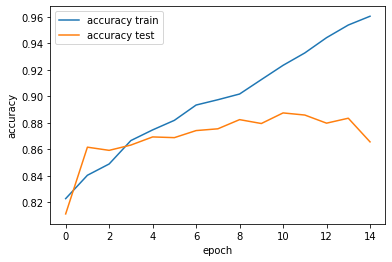

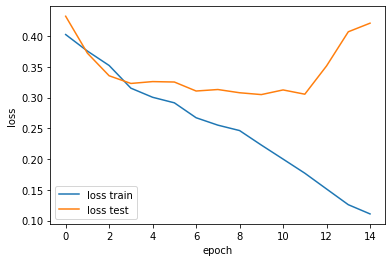

In [ ]:
plot_history(history)

## Word2Vec

In [ ]:
from gensim.models import KeyedVectors
filename = 'drive/MyDrive/training/HW/data/GoogleNews-vectors-negative300.bin'
model = KeyedVectors.load_word2vec_format(filename, binary=True)

In [ ]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
	if word in model.vocab:
		embedding_matrix[i] =  model.word_vec(word)

### LSTM (word2vec)

In [ ]:
checkpoint_filepath = '/tmp/checkpoint_w2v'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable=False, )

model.add(embedding_layer)
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# summarize the model
print(model.summary())

# fit the model
history = model.fit(X_train_pad, y_train, epochs=25, verbose=1, validation_split=0.1,
    callbacks=[model_checkpoint_callback, es_callback])

# evaluate the model
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=0)
print('Accuracy: %f' % (accuracy*100))

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 233, 300)          24680700  
_________________________________________________________________
lstm_16 (LSTM)               (None, 233, 128)          219648    
_________________________________________________________________
lstm_17 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 25,032,061
Trainable params: 351,361
Non-trainable params: 24,680,700
_________________________________________________________________
None
Epoch 1/25
1055/1055 [==============================] - 93s 84ms/step - loss: 0.6906 - accuracy: 

In [ ]:
model.load_weights(checkpoint_filepath)
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=0)
print('Accuracy of the best model on val: %f' % (accuracy*100))

Accuracy of the best model on val: 89.007998


In [ ]:
y_pred_lstm_w2v = model.predict(X_test_pad)

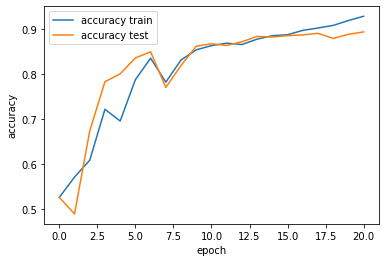

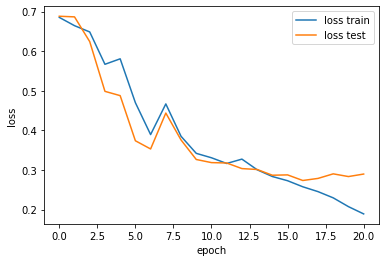

In [ ]:
plot_history(history)

###Bidirectional LSTM (word2vec)

In [ ]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable=False, )

model.add(embedding_layer)
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Bidirectional(LSTM(128)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer=keras.optimizers.adam_v2.Adam(learning_rate=0.0003), loss='binary_crossentropy', metrics=['accuracy'])

# summarize the model
print(model.summary())

# fit the model
history = model.fit(X_train_pad, y_train, epochs=25, verbose=1, validation_split=0.1,
    callbacks=[model_checkpoint_callback, es_callback])

# evaluate the model
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=0)
print('Accuracy: %f' % (accuracy*100))

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 233, 300)          24680700  
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 233, 256)          439296    
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 256)               394240    
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257       
Total params: 25,514,493
Trainable params: 833,793
Non-trainable params: 24,680,700
_________________________________________________________________
None
Epoch 1/25
1055/1055 [==============================] - 195s 177ms/step - loss: 0.4162 - accuracy

In [ ]:
y_pred_blstm_w2v = model.predict(X_test_pad)

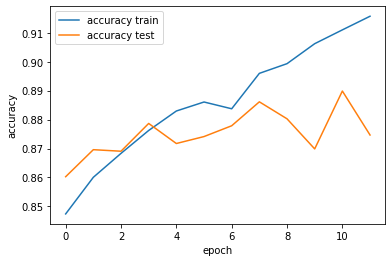

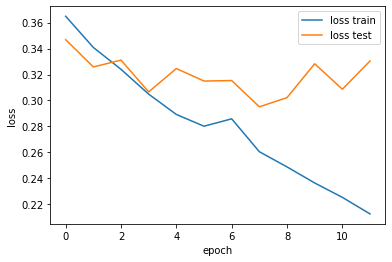

In [ ]:
plot_history(history)

# Results

We can see, that LSTM with word2vec embeddings showed the best results. Let's check the confusion matrix.

In [ ]:
def conf_matrix(y_true, y_pred, target_names):
  conf = confusion_matrix(y_true, y_pred)
  print(conf)
  sns.heatmap(conf,
              annot=conf/np.sum(conf, axis=1)[:, np.newaxis], #normalized by true class sizes
              yticklabels=target_names,
              xticklabels=target_names,
              cmap='bwr');
  plt.title('Logistic regression confusion matrix');
  plt.xlabel('Predicted label');
  plt.ylabel('True label');

In [ ]:
y_p = [1 if i else 0 for i in y_pred_lstm_w2v > 0.5]

[[5490  667]
 [ 707 5636]]


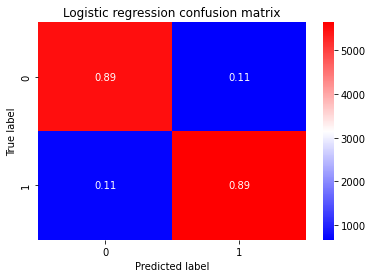

In [ ]:
conf_matrix(y_test, y_p, ['0', '1'])

As can be seen, neural network make almost the same number of errors for each class. 

Some insights and conclusions:

* Almost all NNs showed accuracy about 0.88, despite the best.
* The best NN showed acc=0.89, and it is almost the same as the classical model's result (0.892). Probably, another starting weights can lead to better accurqacy score for NN.
* The best learning curves can be seen also for the best score NN, other one overfitted (but we chose the best score thanks to early stopping and model checkpoints)